Processando evento 0 de 10000...
Processando evento 1000 de 10000...
Processando evento 2000 de 10000...
Processando evento 3000 de 10000...
Processando evento 4000 de 10000...
Processando evento 5000 de 10000...
Processando evento 6000 de 10000...
Processando evento 7000 de 10000...
Processando evento 8000 de 10000...
Processando evento 9000 de 10000...


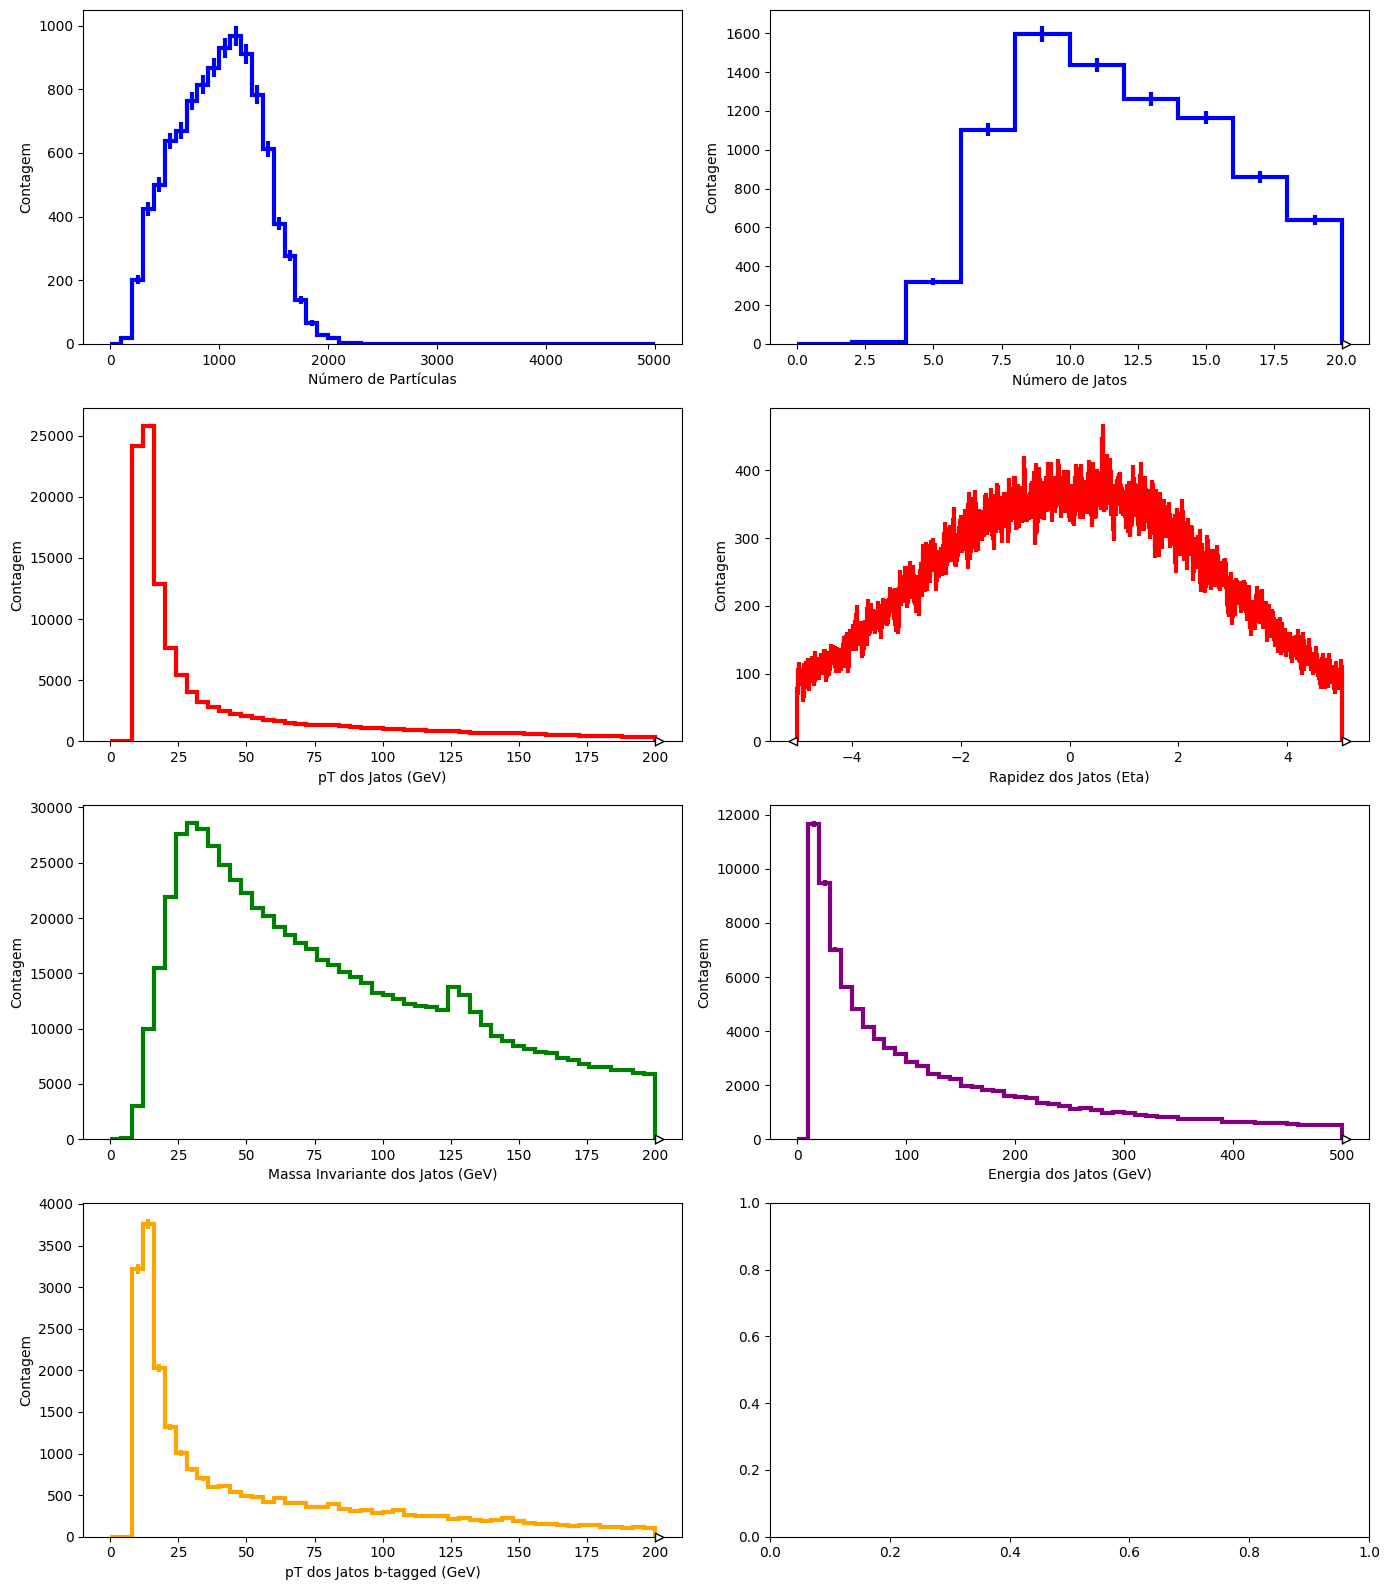

In [3]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/Jets_2b2mu.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_jets_eta = hist.Hist.new.Reg(500, -5., +5.).Double()
histo_jets_mass = hist.Hist.new.Reg(50, 0., 200.).Double()  # Massa invariante dos jatos
histo_npart = hist.Hist.new.Reg(50, 0., 5000.).Double()
histo_jets_energy = hist.Hist.new.Reg(50, 0., 500.).Double()  # Energia dos jatos
histo_rjj = hist.Hist.new.Reg(50, 0., 5.0).Double()  # Separação entre jatos (Rjj)
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()  # pT dos jatos b-tagged

# Função para ler o arquivo HEPMC e extrair os eventos
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            events.append(event)  # Adiciona o evento ao arquivo
    return events

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan  # Retorna NaN se não puder calcular
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para identificar descendentes de quarks b ao longo da cadeia de decaimento
def get_b_descendants(event):
    b_descendants = []
    for particle in event.particles:
        if abs(particle.pid) == 5:  # IDs do PDG para quarks b (5) e b~ (-5)
            to_process = [particle]
            while to_process:
                current = to_process.pop()
                if current.end_vertex:
                    to_process.extend(current.end_vertex.particles_out)
                b_descendants.append({
                    'eta': get_eta(current),
                    'phi': np.arctan2(current.momentum.y, current.momentum.x)
                })
    return b_descendants

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, b_descendants, cone_radius=0.4):
    for b in b_descendants:
        delta_eta = jet.eta() - b['eta']
        delta_phi = jet.phi() - b['phi']
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        if delta_r < cone_radius:
            return True
    return False

# Função para analisar o evento e preencher os histogramas
def analyze_event(event):
    # Filtrar partículas com status 1 (partículas finais)
    particles = [p for p in event.particles if p.status == 1]
    
    # Converter partículas para objetos PseudoJet do FastJet
    fj_particles = [
        fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e)
        for p in particles
    ]

    # Escolher o algoritmo de clustering (anti-kT, por exemplo)
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)  # Radius de 0.4
    
    # Clustering dos jatos
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(10.0)  # Jatos com pT > 10 GeV

    # Preencher histogramas gerais de jatos
    histo_njets.fill(len(jets))
    for jet in jets:
        histo_jets_pt.fill(jet.pt())
        histo_jets_eta.fill(jet.eta())
        histo_jets_energy.fill(jet.e())

    # Preencher histograma de massa invariante e separação Rjj entre jatos
    if len(jets) >= 2:
        for i in range(len(jets) - 1):
            for j in range(i + 1, len(jets)):
                histo_jets_mass.fill(invariant_mass(jets[i], jets[j]))
                histo_rjj.fill(delta_r(jets[i], jets[j]))

    # Identificar descendentes de quarks b
    b_descendants = get_b_descendants(event)

    # Preencher histogramas específicos para jatos b-tagged
    for jet in jets:
        if is_b_tagged(jet, b_descendants):
            histo_bjets_pt.fill(jet.pt())

    # Preencher histograma de número de partículas
    histo_npart.fill(len(particles))

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para calcular a separação angular R entre dois jatos
def delta_r(jet1, jet2):
    delta_eta = jet1.eta() - jet2.eta()
    delta_phi = jet1.phi() - jet2.phi()
    return np.sqrt(delta_eta**2 + delta_phi**2)

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(4, 2, figsize=(14, 16))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Contagem')

    histo_bjets_pt.plot(ax=ax[3, 0], ls="-", color="orange", lw=3)
    ax[3, 0].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Loop sobre os eventos e realizar a análise
for ievt, event in enumerate(events):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {len(events)}...")
    analyze_event(event)

# Plotar os histogramas
plot_histograms()


/tmp/ipykernel_400/1073302840.py:41: RuntimeWarning: divide by zero encountered in log
  eta = 0.5 * np.log(e_plus_pz / e_minus_pz)


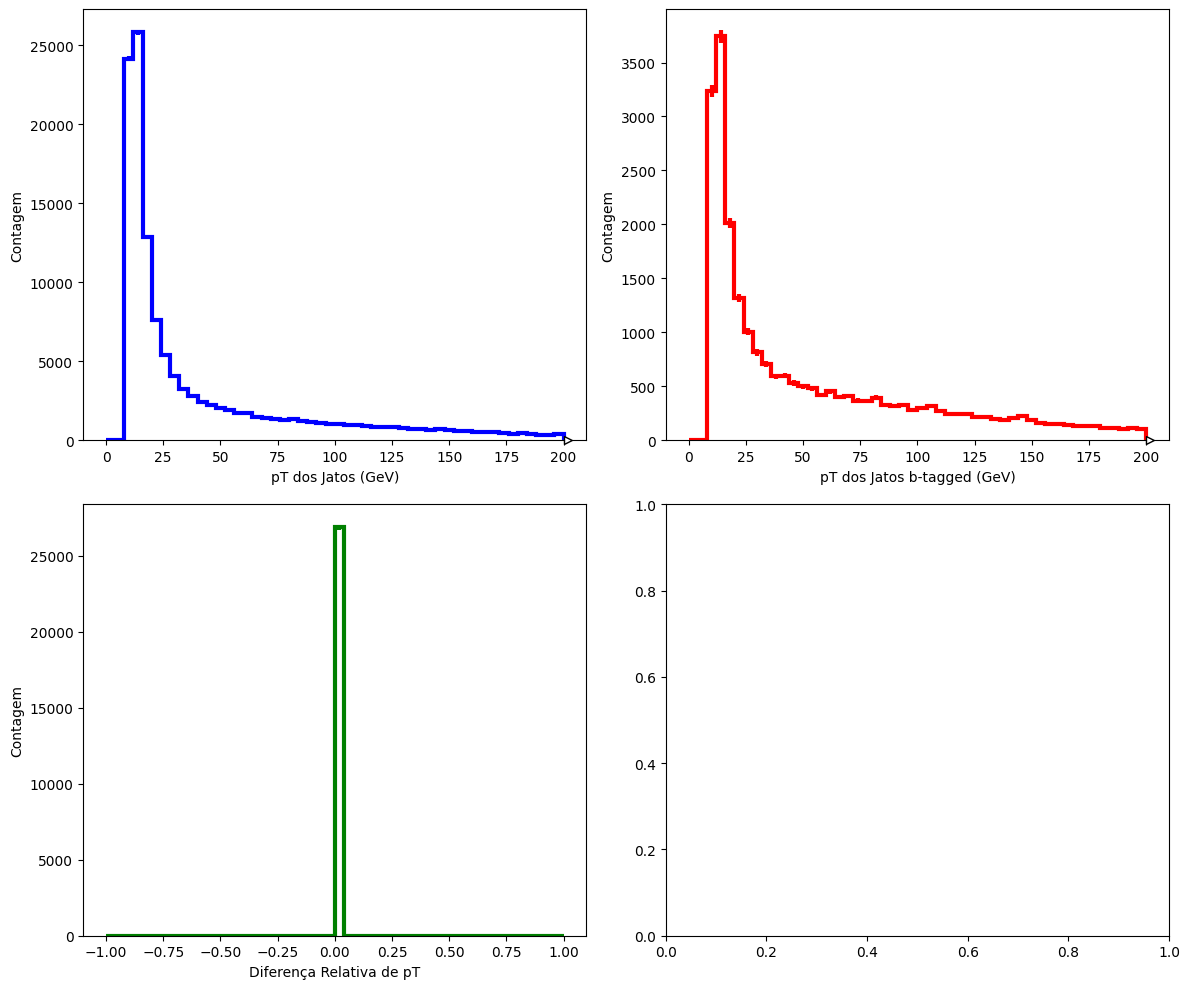

In [6]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/Jets_2b2mu.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_relative_pt_diff = hist.Hist.new.Reg(50, -1.0, 1.0).Double()  # Diferença relativa

# Funções auxiliares para cálculos
def get_pt(particle):
    return np.sqrt(particle.momentum.x**2 + particle.momentum.y**2)

def delta_r(jet, b_descendant):
    delta_eta = jet.eta() - b_descendant['eta']
    delta_phi = jet.phi() - b_descendant['phi']
    return np.sqrt(delta_eta**2 + delta_phi**2)

# Identificar descendentes de quarks b
def get_b_descendants(event):
    b_descendants = []
    for particle in event.particles:
        if abs(particle.pid) == 5:  # Quark b ou b~
            queue = [particle]
            while queue:
                p = queue.pop()
                if p.end_vertex:
                    for daughter in p.end_vertex.particles_out:
                        # Evitar divisão por zero no cálculo de eta
                        e_plus_pz = daughter.momentum.e + daughter.momentum.z
                        e_minus_pz = daughter.momentum.e - daughter.momentum.z
                        if e_minus_pz == 0:
                            eta = np.inf if e_plus_pz > 0 else -np.inf
                        else:
                            eta = 0.5 * np.log(e_plus_pz / e_minus_pz)
                        
                        b_descendants.append({
                            'eta': eta,
                            'phi': np.arctan2(daughter.momentum.y, daughter.momentum.x),
                        })
                        queue.append(daughter)
    return b_descendants

# Verificar se um jato é b-tagged
def is_b_tagged(jet, b_descendants, radius=0.4):
    for b in b_descendants:
        if delta_r(jet, b) < radius:
            return True
    return False

# Analisar eventos e preencher histogramas
def analyze_event(event):
    particles = [p for p in event.particles if p.status == 1]
    b_descendants = get_b_descendants(event)

    fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]

    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(10.0)

    histo_njets.fill(len(jets))

    for jet in jets:
        histo_jets_pt.fill(jet.pt())

        if is_b_tagged(jet, b_descendants):
            histo_bjets_pt.fill(jet.pt())

            # Diferença relativa
            relative_diff = (jet.pt() - jet.pt()) / jet.pt()  # Aqui jet.pt() é apenas uma comparação com ele mesmo
            histo_relative_pt_diff.fill(relative_diff)

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    histo_jets_pt.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_bjets_pt.plot(ax=ax[0, 1], ls="-", color="red", lw=3)
    ax[0, 1].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem')

    histo_relative_pt_diff.plot(ax=ax[1, 0], ls="-", color="green", lw=3)
    ax[1, 0].set(xlabel='Diferença Relativa de pT', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Loop sobre os eventos e realizar a análise
for event in events:
    analyze_event(event)

# Plotar os histogramas
plot_histograms()
